<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[05:10:25] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


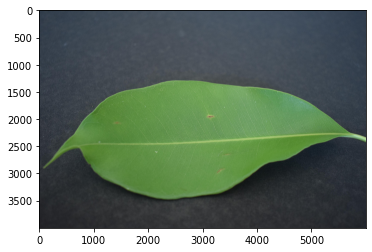

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

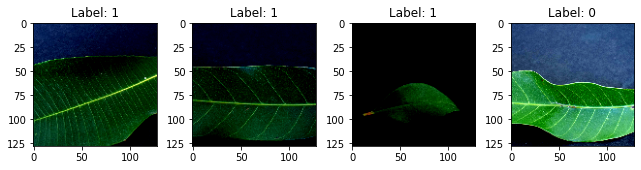

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[05:10:30] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[05:10:32] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2570000409829034 samples/sec                   batch loss = 0.9684380888938904 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2742563579082322 samples/sec                   batch loss = 0.7960455417633057 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2626780592473401 samples/sec                   batch loss = 1.043828010559082 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2612148536826933 samples/sec                   batch loss = 0.39631667733192444 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2701226144248248 samples/sec                   batch loss = 1.789513111114502 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.258347573971314 samples/sec                   batch loss = 0.38460254669189453 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2711884235072195 samples/sec                   batch loss = 0.104202039539814 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2656568800620531 samples/sec                   batch loss = 0.6499601006507874 | accuracy = 0.55625


Epoch[1] Batch[45] Speed: 1.2669544444479686 samples/sec                   batch loss = 0.24034304916858673 | accuracy = 0.5833333333333334


Epoch[1] Batch[50] Speed: 1.2666236839045661 samples/sec                   batch loss = 1.324594497680664 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.2709029097067568 samples/sec                   batch loss = 0.9047189950942993 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.2736042856076826 samples/sec                   batch loss = 2.136343479156494 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2730899476512336 samples/sec                   batch loss = 0.5185931324958801 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2724672486300883 samples/sec                   batch loss = 0.47850292921066284 | accuracy = 0.6142857142857143


Epoch[1] Batch[75] Speed: 1.2681916871585168 samples/sec                   batch loss = 0.8995304703712463 | accuracy = 0.6133333333333333


Epoch[1] Batch[80] Speed: 1.2689197031566326 samples/sec                   batch loss = 0.6808773875236511 | accuracy = 0.615625


Epoch[1] Batch[85] Speed: 1.2673495173074794 samples/sec                   batch loss = 0.4292064309120178 | accuracy = 0.6176470588235294


Epoch[1] Batch[90] Speed: 1.2680700489897896 samples/sec                   batch loss = 0.6867638230323792 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.2725121274677123 samples/sec                   batch loss = 0.4773954153060913 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2672263177243002 samples/sec                   batch loss = 0.642029345035553 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.2646199589691622 samples/sec                   batch loss = 0.43962714076042175 | accuracy = 0.6333333333333333


Epoch[1] Batch[110] Speed: 1.2649309808347744 samples/sec                   batch loss = 0.49999845027923584 | accuracy = 0.6295454545454545


Epoch[1] Batch[115] Speed: 1.2642437335891377 samples/sec                   batch loss = 0.5632138252258301 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.267867083111974 samples/sec                   batch loss = 0.3538459241390228 | accuracy = 0.6395833333333333


Epoch[1] Batch[125] Speed: 1.2639004851456126 samples/sec                   batch loss = 0.5378314256668091 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.268856460201514 samples/sec                   batch loss = 0.5797327160835266 | accuracy = 0.6384615384615384


Epoch[1] Batch[135] Speed: 1.266782920962809 samples/sec                   batch loss = 0.33031728863716125 | accuracy = 0.6407407407407407


Epoch[1] Batch[140] Speed: 1.2691909804099863 samples/sec                   batch loss = 0.45113301277160645 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.2766281440948166 samples/sec                   batch loss = 0.6369197964668274 | accuracy = 0.6482758620689655


Epoch[1] Batch[150] Speed: 1.2750723636240378 samples/sec                   batch loss = 0.7388765215873718 | accuracy = 0.65


Epoch[1] Batch[155] Speed: 1.274791592456115 samples/sec                   batch loss = 0.7293311953544617 | accuracy = 0.6483870967741936


Epoch[1] Batch[160] Speed: 1.271737663841091 samples/sec                   batch loss = 0.34280869364738464 | accuracy = 0.6578125


Epoch[1] Batch[165] Speed: 1.273403023870098 samples/sec                   batch loss = 0.4806382656097412 | accuracy = 0.656060606060606


Epoch[1] Batch[170] Speed: 1.2726362604804158 samples/sec                   batch loss = 0.5286139249801636 | accuracy = 0.6602941176470588


Epoch[1] Batch[175] Speed: 1.2822301483682519 samples/sec                   batch loss = 0.5354862213134766 | accuracy = 0.66


Epoch[1] Batch[180] Speed: 1.27019829283671 samples/sec                   batch loss = 0.26654401421546936 | accuracy = 0.6597222222222222


Epoch[1] Batch[185] Speed: 1.2675341221957577 samples/sec                   batch loss = 0.1993369609117508 | accuracy = 0.6648648648648648


Epoch[1] Batch[190] Speed: 1.262513581986435 samples/sec                   batch loss = 0.3818455934524536 | accuracy = 0.6644736842105263


Epoch[1] Batch[195] Speed: 1.2675261738858519 samples/sec                   batch loss = 0.4809493124485016 | accuracy = 0.6666666666666666


Epoch[1] Batch[200] Speed: 1.2754939462903614 samples/sec                   batch loss = 0.6341492533683777 | accuracy = 0.66375


Epoch[1] Batch[205] Speed: 1.277152637148837 samples/sec                   batch loss = 0.9479321241378784 | accuracy = 0.6621951219512195


Epoch[1] Batch[210] Speed: 1.2707015383417533 samples/sec                   batch loss = 0.8547095060348511 | accuracy = 0.6583333333333333


Epoch[1] Batch[215] Speed: 1.2697462795482586 samples/sec                   batch loss = 0.637940526008606 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.2746874730992894 samples/sec                   batch loss = 2.249251365661621 | accuracy = 0.6556818181818181


Epoch[1] Batch[225] Speed: 1.2739866840984255 samples/sec                   batch loss = 0.5286245942115784 | accuracy = 0.6555555555555556


Epoch[1] Batch[230] Speed: 1.2714378354324254 samples/sec                   batch loss = 0.8177645206451416 | accuracy = 0.6597826086956522


Epoch[1] Batch[235] Speed: 1.2795305433362651 samples/sec                   batch loss = 0.4362661838531494 | accuracy = 0.6627659574468086


Epoch[1] Batch[240] Speed: 1.2706397536155434 samples/sec                   batch loss = 0.84017014503479 | accuracy = 0.6635416666666667


Epoch[1] Batch[245] Speed: 1.2630130373909378 samples/sec                   batch loss = 0.5721518993377686 | accuracy = 0.6663265306122449


Epoch[1] Batch[250] Speed: 1.2662843986668144 samples/sec                   batch loss = 0.5592153668403625 | accuracy = 0.667


Epoch[1] Batch[255] Speed: 1.2612908017848046 samples/sec                   batch loss = 1.0099626779556274 | accuracy = 0.6656862745098039


Epoch[1] Batch[260] Speed: 1.2667437057193758 samples/sec                   batch loss = 0.8112515211105347 | accuracy = 0.6634615384615384


Epoch[1] Batch[265] Speed: 1.2673879083972188 samples/sec                   batch loss = 0.6848517656326294 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.2686418266513286 samples/sec                   batch loss = 0.7874283790588379 | accuracy = 0.6666666666666666


Epoch[1] Batch[275] Speed: 1.2665127676310772 samples/sec                   batch loss = 0.6383779048919678 | accuracy = 0.6663636363636364


Epoch[1] Batch[280] Speed: 1.2674058122692247 samples/sec                   batch loss = 0.5580029487609863 | accuracy = 0.6669642857142857


Epoch[1] Batch[285] Speed: 1.2708651717812327 samples/sec                   batch loss = 0.3640138506889343 | accuracy = 0.6666666666666666


Epoch[1] Batch[290] Speed: 1.2667218992686298 samples/sec                   batch loss = 0.4060879051685333 | accuracy = 0.6655172413793103


Epoch[1] Batch[295] Speed: 1.267737652033806 samples/sec                   batch loss = 0.3389970064163208 | accuracy = 0.6677966101694915


Epoch[1] Batch[300] Speed: 1.2653131502256636 samples/sec                   batch loss = 0.9283109307289124 | accuracy = 0.6683333333333333


Epoch[1] Batch[305] Speed: 1.2662517129877473 samples/sec                   batch loss = 0.9918293356895447 | accuracy = 0.6663934426229509


Epoch[1] Batch[310] Speed: 1.2629439169636922 samples/sec                   batch loss = 0.6457827091217041 | accuracy = 0.6669354838709678


Epoch[1] Batch[315] Speed: 1.271570047055141 samples/sec                   batch loss = 0.41970568895339966 | accuracy = 0.6666666666666666


Epoch[1] Batch[320] Speed: 1.2700100270228494 samples/sec                   batch loss = 0.3797904849052429 | accuracy = 0.66640625


Epoch[1] Batch[325] Speed: 1.27156214442174 samples/sec                   batch loss = 0.8378772139549255 | accuracy = 0.6692307692307692


Epoch[1] Batch[330] Speed: 1.2709522034339737 samples/sec                   batch loss = 0.6035288572311401 | accuracy = 0.668939393939394


Epoch[1] Batch[335] Speed: 1.2764971124161237 samples/sec                   batch loss = 0.73345947265625 | accuracy = 0.6686567164179105


Epoch[1] Batch[340] Speed: 1.2758396406493382 samples/sec                   batch loss = 0.1562570333480835 | accuracy = 0.6713235294117647


Epoch[1] Batch[345] Speed: 1.2686319458538493 samples/sec                   batch loss = 0.7379618883132935 | accuracy = 0.672463768115942


Epoch[1] Batch[350] Speed: 1.2706754571403815 samples/sec                   batch loss = 0.6537514925003052 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.2685411072874657 samples/sec                   batch loss = 0.5100796222686768 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.2718370595827182 samples/sec                   batch loss = 0.6202473640441895 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.2739183887224177 samples/sec                   batch loss = 0.6722981929779053 | accuracy = 0.6732876712328767


Epoch[1] Batch[370] Speed: 1.2750979472684587 samples/sec                   batch loss = 0.28220635652542114 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.2683264845189732 samples/sec                   batch loss = 0.9090458750724792 | accuracy = 0.674


Epoch[1] Batch[380] Speed: 1.2746157132863436 samples/sec                   batch loss = 0.35617297887802124 | accuracy = 0.6756578947368421


Epoch[1] Batch[385] Speed: 1.2717689944785606 samples/sec                   batch loss = 0.3643335998058319 | accuracy = 0.6772727272727272


Epoch[1] Batch[390] Speed: 1.266701049943257 samples/sec                   batch loss = 0.4405740797519684 | accuracy = 0.6782051282051282


Epoch[1] Batch[395] Speed: 1.267076921310831 samples/sec                   batch loss = 0.5279296040534973 | accuracy = 0.6778481012658227


Epoch[1] Batch[400] Speed: 1.2684535424002943 samples/sec                   batch loss = 0.6800848841667175 | accuracy = 0.68


Epoch[1] Batch[405] Speed: 1.272290177010391 samples/sec                   batch loss = 1.1852197647094727 | accuracy = 0.678395061728395


Epoch[1] Batch[410] Speed: 1.271943992425901 samples/sec                   batch loss = 0.44776856899261475 | accuracy = 0.676829268292683


Epoch[1] Batch[415] Speed: 1.2733862066049921 samples/sec                   batch loss = 0.24812445044517517 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.2706887382087708 samples/sec                   batch loss = 0.6616196036338806 | accuracy = 0.6779761904761905


Epoch[1] Batch[425] Speed: 1.2748939850049716 samples/sec                   batch loss = 0.792186975479126 | accuracy = 0.678235294117647


Epoch[1] Batch[430] Speed: 1.2644666972912333 samples/sec                   batch loss = 0.6408356428146362 | accuracy = 0.6790697674418604


Epoch[1] Batch[435] Speed: 1.270592119961376 samples/sec                   batch loss = 0.5191914439201355 | accuracy = 0.6793103448275862


Epoch[1] Batch[440] Speed: 1.272992867325455 samples/sec                   batch loss = 0.4263983368873596 | accuracy = 0.6806818181818182


Epoch[1] Batch[445] Speed: 1.2666408011632078 samples/sec                   batch loss = 0.7285038232803345 | accuracy = 0.6820224719101123


Epoch[1] Batch[450] Speed: 1.2707593827598869 samples/sec                   batch loss = 0.4204525947570801 | accuracy = 0.6816666666666666


Epoch[1] Batch[455] Speed: 1.2668539928228892 samples/sec                   batch loss = 0.3179521858692169 | accuracy = 0.6824175824175824


Epoch[1] Batch[460] Speed: 1.270648510898187 samples/sec                   batch loss = 0.6308860778808594 | accuracy = 0.6826086956521739


Epoch[1] Batch[465] Speed: 1.2726324955928356 samples/sec                   batch loss = 0.45788389444351196 | accuracy = 0.6827956989247311


Epoch[1] Batch[470] Speed: 1.2646715311080166 samples/sec                   batch loss = 0.4683709442615509 | accuracy = 0.6819148936170213


Epoch[1] Batch[475] Speed: 1.2711869787637906 samples/sec                   batch loss = 0.40473729372024536 | accuracy = 0.6815789473684211


Epoch[1] Batch[480] Speed: 1.2638437394889774 samples/sec                   batch loss = 0.28646957874298096 | accuracy = 0.6828125


Epoch[1] Batch[485] Speed: 1.2629935459956123 samples/sec                   batch loss = 0.29660531878471375 | accuracy = 0.6845360824742268


Epoch[1] Batch[490] Speed: 1.2705466066951954 samples/sec                   batch loss = 0.29714420437812805 | accuracy = 0.686734693877551


Epoch[1] Batch[495] Speed: 1.273003202536474 samples/sec                   batch loss = 0.24791711568832397 | accuracy = 0.6868686868686869


Epoch[1] Batch[500] Speed: 1.2729868787753018 samples/sec                   batch loss = 0.42523330450057983 | accuracy = 0.687


Epoch[1] Batch[505] Speed: 1.2741274575830455 samples/sec                   batch loss = 0.26059451699256897 | accuracy = 0.6876237623762376


Epoch[1] Batch[510] Speed: 1.2752829747087968 samples/sec                   batch loss = 0.2354842722415924 | accuracy = 0.6887254901960784


Epoch[1] Batch[515] Speed: 1.2722431913457335 samples/sec                   batch loss = 0.7636514902114868 | accuracy = 0.6888349514563107


Epoch[1] Batch[520] Speed: 1.2699873388956604 samples/sec                   batch loss = 0.45451146364212036 | accuracy = 0.6879807692307692


Epoch[1] Batch[525] Speed: 1.2706158882272294 samples/sec                   batch loss = 0.8152655363082886 | accuracy = 0.6866666666666666


Epoch[1] Batch[530] Speed: 1.2777856732344173 samples/sec                   batch loss = 1.1106045246124268 | accuracy = 0.6867924528301886


Epoch[1] Batch[535] Speed: 1.2809220504414303 samples/sec                   batch loss = 0.4845944344997406 | accuracy = 0.6869158878504673


Epoch[1] Batch[540] Speed: 1.2762452264083284 samples/sec                   batch loss = 0.42533785104751587 | accuracy = 0.6861111111111111


Epoch[1] Batch[545] Speed: 1.2734015740883686 samples/sec                   batch loss = 0.8397120833396912 | accuracy = 0.6853211009174311


Epoch[1] Batch[550] Speed: 1.2695965766359703 samples/sec                   batch loss = 0.7708484530448914 | accuracy = 0.6854545454545454


Epoch[1] Batch[555] Speed: 1.2678104597512578 samples/sec                   batch loss = 0.6321859359741211 | accuracy = 0.686036036036036


Epoch[1] Batch[560] Speed: 1.2671616164263482 samples/sec                   batch loss = 0.8462067246437073 | accuracy = 0.6857142857142857


Epoch[1] Batch[565] Speed: 1.2621321521186313 samples/sec                   batch loss = 0.5478622317314148 | accuracy = 0.6862831858407079


Epoch[1] Batch[570] Speed: 1.2630853034234086 samples/sec                   batch loss = 0.9338614344596863 | accuracy = 0.6855263157894737


Epoch[1] Batch[575] Speed: 1.2650426694748538 samples/sec                   batch loss = 0.5755749940872192 | accuracy = 0.6860869565217391


Epoch[1] Batch[580] Speed: 1.2651130692030637 samples/sec                   batch loss = 0.425639271736145 | accuracy = 0.6866379310344828


Epoch[1] Batch[585] Speed: 1.2645418938081885 samples/sec                   batch loss = 0.9416913390159607 | accuracy = 0.685042735042735


Epoch[1] Batch[590] Speed: 1.2647554282314624 samples/sec                   batch loss = 0.45918527245521545 | accuracy = 0.6851694915254237


Epoch[1] Batch[595] Speed: 1.266677619181074 samples/sec                   batch loss = 0.31188133358955383 | accuracy = 0.684453781512605


Epoch[1] Batch[600] Speed: 1.264588407664225 samples/sec                   batch loss = 0.708858072757721 | accuracy = 0.6845833333333333


Epoch[1] Batch[605] Speed: 1.266154526068697 samples/sec                   batch loss = 0.25185564160346985 | accuracy = 0.6863636363636364


Epoch[1] Batch[610] Speed: 1.263507369059372 samples/sec                   batch loss = 0.28171274065971375 | accuracy = 0.6872950819672131


Epoch[1] Batch[615] Speed: 1.2661398107659667 samples/sec                   batch loss = 0.2794872522354126 | accuracy = 0.6873983739837398


Epoch[1] Batch[620] Speed: 1.271398716856399 samples/sec                   batch loss = 0.15462782979011536 | accuracy = 0.6891129032258064


Epoch[1] Batch[625] Speed: 1.2693632527058076 samples/sec                   batch loss = 0.5458422899246216 | accuracy = 0.6896


Epoch[1] Batch[630] Speed: 1.2714840871006543 samples/sec                   batch loss = 0.8472694158554077 | accuracy = 0.6880952380952381


Epoch[1] Batch[635] Speed: 1.2691769625371048 samples/sec                   batch loss = 0.6932998299598694 | accuracy = 0.6889763779527559


Epoch[1] Batch[640] Speed: 1.2674033229305415 samples/sec                   batch loss = 0.27957576513290405 | accuracy = 0.691015625


Epoch[1] Batch[645] Speed: 1.269366518072673 samples/sec                   batch loss = 0.3509528934955597 | accuracy = 0.689922480620155


Epoch[1] Batch[650] Speed: 1.2677190682456594 samples/sec                   batch loss = 0.7936486005783081 | accuracy = 0.6884615384615385


Epoch[1] Batch[655] Speed: 1.266579028206594 samples/sec                   batch loss = 0.9987178444862366 | accuracy = 0.6885496183206107


Epoch[1] Batch[660] Speed: 1.2648488722204707 samples/sec                   batch loss = 0.48618653416633606 | accuracy = 0.6886363636363636


Epoch[1] Batch[665] Speed: 1.2668931192286104 samples/sec                   batch loss = 0.21848075091838837 | accuracy = 0.6898496240601504


Epoch[1] Batch[670] Speed: 1.2740952365763982 samples/sec                   batch loss = 0.4039229452610016 | accuracy = 0.6906716417910448


Epoch[1] Batch[675] Speed: 1.2641420920517477 samples/sec                   batch loss = 0.38799214363098145 | accuracy = 0.6918518518518518


Epoch[1] Batch[680] Speed: 1.2678925700653338 samples/sec                   batch loss = 0.23809808492660522 | accuracy = 0.6919117647058823


Epoch[1] Batch[685] Speed: 1.269852188292654 samples/sec                   batch loss = 0.38851404190063477 | accuracy = 0.691970802919708


Epoch[1] Batch[690] Speed: 1.2666800100354616 samples/sec                   batch loss = 0.3312250077724457 | accuracy = 0.6920289855072463


Epoch[1] Batch[695] Speed: 1.2681700225458785 samples/sec                   batch loss = 0.2757872939109802 | accuracy = 0.6928057553956835


Epoch[1] Batch[700] Speed: 1.2686448005137125 samples/sec                   batch loss = 0.5002515912055969 | accuracy = 0.6932142857142857


Epoch[1] Batch[705] Speed: 1.2713950556350373 samples/sec                   batch loss = 0.4497651755809784 | accuracy = 0.6946808510638298


Epoch[1] Batch[710] Speed: 1.2738917883974303 samples/sec                   batch loss = 1.1186610460281372 | accuracy = 0.6943661971830986


Epoch[1] Batch[715] Speed: 1.2738282422998617 samples/sec                   batch loss = 0.6316088438034058 | accuracy = 0.6944055944055944


Epoch[1] Batch[720] Speed: 1.2676597761929653 samples/sec                   batch loss = 0.610788106918335 | accuracy = 0.6940972222222223


Epoch[1] Batch[725] Speed: 1.2657696519016064 samples/sec                   batch loss = 1.6806360483169556 | accuracy = 0.6934482758620689


Epoch[1] Batch[730] Speed: 1.2663897306678777 samples/sec                   batch loss = 0.630380392074585 | accuracy = 0.6934931506849316


Epoch[1] Batch[735] Speed: 1.2619774044489602 samples/sec                   batch loss = 0.41275808215141296 | accuracy = 0.6942176870748299


Epoch[1] Batch[740] Speed: 1.2622985244531921 samples/sec                   batch loss = 1.0185030698776245 | accuracy = 0.6942567567567568


Epoch[1] Batch[745] Speed: 1.2654754942019084 samples/sec                   batch loss = 0.4979093074798584 | accuracy = 0.6939597315436241


Epoch[1] Batch[750] Speed: 1.2685227876746872 samples/sec                   batch loss = 0.5833411812782288 | accuracy = 0.6943333333333334


Epoch[1] Batch[755] Speed: 1.2686754033268859 samples/sec                   batch loss = 0.8799353837966919 | accuracy = 0.6937086092715232


Epoch[1] Batch[760] Speed: 1.2705710468175586 samples/sec                   batch loss = 0.7116181254386902 | accuracy = 0.69375


Epoch[1] Batch[765] Speed: 1.2672955247980187 samples/sec                   batch loss = 0.5638535022735596 | accuracy = 0.6947712418300653


Epoch[1] Batch[770] Speed: 1.2605340998371928 samples/sec                   batch loss = 0.5645626187324524 | accuracy = 0.6941558441558442


Epoch[1] Batch[775] Speed: 1.2709334290049985 samples/sec                   batch loss = 0.32322677969932556 | accuracy = 0.6948387096774193


Epoch[1] Batch[780] Speed: 1.2639925648630714 samples/sec                   batch loss = 0.2980019450187683 | accuracy = 0.6942307692307692


Epoch[1] Batch[785] Speed: 1.2665202251851064 samples/sec                   batch loss = 0.44142740964889526 | accuracy = 0.6952229299363057


[Epoch 1] training: accuracy=0.694479695431472
[Epoch 1] time cost: 648.0942866802216
[Epoch 1] validation: validation accuracy=0.6933333333333334


Epoch[2] Batch[5] Speed: 1.2721637963541985 samples/sec                   batch loss = 0.5510151386260986 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.260755093679578 samples/sec                   batch loss = 0.4838051497936249 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.260928305458035 samples/sec                   batch loss = 0.3897804319858551 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2660778955772742 samples/sec                   batch loss = 0.2905568778514862 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.2630350966713428 samples/sec                   batch loss = 0.46981245279312134 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.2637483497174586 samples/sec                   batch loss = 0.6916959285736084 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2612770526987802 samples/sec                   batch loss = 0.29032230377197266 | accuracy = 0.7928571428571428


Epoch[2] Batch[40] Speed: 1.259459600671543 samples/sec                   batch loss = 0.7540324330329895 | accuracy = 0.79375


Epoch[2] Batch[45] Speed: 1.2649967898584409 samples/sec                   batch loss = 0.3722013235092163 | accuracy = 0.7944444444444444


Epoch[2] Batch[50] Speed: 1.2653844390113218 samples/sec                   batch loss = 0.1570315659046173 | accuracy = 0.79


Epoch[2] Batch[55] Speed: 1.2631653762372868 samples/sec                   batch loss = 0.2769591212272644 | accuracy = 0.7863636363636364


Epoch[2] Batch[60] Speed: 1.2636906658849265 samples/sec                   batch loss = 0.28149738907814026 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.2624070889524661 samples/sec                   batch loss = 0.2509952187538147 | accuracy = 0.7807692307692308


Epoch[2] Batch[70] Speed: 1.2623840067478775 samples/sec                   batch loss = 0.14783552289009094 | accuracy = 0.7821428571428571


Epoch[2] Batch[75] Speed: 1.265458503874243 samples/sec                   batch loss = 0.4798610508441925 | accuracy = 0.78


Epoch[2] Batch[80] Speed: 1.2683293610195552 samples/sec                   batch loss = 0.8299102783203125 | accuracy = 0.759375


Epoch[2] Batch[85] Speed: 1.2607293244405355 samples/sec                   batch loss = 0.13072916865348816 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.261562715974132 samples/sec                   batch loss = 0.39241182804107666 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.266459133195107 samples/sec                   batch loss = 0.26970621943473816 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.2656011222419008 samples/sec                   batch loss = 0.7018307447433472 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2655807871363067 samples/sec                   batch loss = 1.2034947872161865 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2620299954121583 samples/sec                   batch loss = 0.4333561062812805 | accuracy = 0.740909090909091


Epoch[2] Batch[115] Speed: 1.2641751451914003 samples/sec                   batch loss = 0.6277647614479065 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.2651296686544613 samples/sec                   batch loss = 0.4236864745616913 | accuracy = 0.7416666666666667


Epoch[2] Batch[125] Speed: 1.2658580882476658 samples/sec                   batch loss = 1.2601984739303589 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.2641234230306655 samples/sec                   batch loss = 0.3465542495250702 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2609562625848798 samples/sec                   batch loss = 0.3286776542663574 | accuracy = 0.7462962962962963


Epoch[2] Batch[140] Speed: 1.2588081295584033 samples/sec                   batch loss = 0.1419946253299713 | accuracy = 0.7446428571428572


Epoch[2] Batch[145] Speed: 1.264627680223142 samples/sec                   batch loss = 0.7137197852134705 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.2683741402277404 samples/sec                   batch loss = 0.31048426032066345 | accuracy = 0.7433333333333333


Epoch[2] Batch[155] Speed: 1.2587480626093241 samples/sec                   batch loss = 0.37006673216819763 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.260057138578289 samples/sec                   batch loss = 0.2579522132873535 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2601426015101387 samples/sec                   batch loss = 0.5723105669021606 | accuracy = 0.75


Epoch[2] Batch[170] Speed: 1.2653202119423663 samples/sec                   batch loss = 0.41892528533935547 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2666486427434696 samples/sec                   batch loss = 0.2993791103363037 | accuracy = 0.7457142857142857


Epoch[2] Batch[180] Speed: 1.2683794142184128 samples/sec                   batch loss = 0.26790228486061096 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.2635215474456514 samples/sec                   batch loss = 0.18142597377300262 | accuracy = 0.7472972972972973


Epoch[2] Batch[190] Speed: 1.2656727299282144 samples/sec                   batch loss = 0.248790442943573 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.2672492901886467 samples/sec                   batch loss = 0.5748911499977112 | accuracy = 0.7435897435897436


Epoch[2] Batch[200] Speed: 1.2666670995289904 samples/sec                   batch loss = 0.41125813126564026 | accuracy = 0.7425


Epoch[2] Batch[205] Speed: 1.269103421784651 samples/sec                   batch loss = 0.17672257125377655 | accuracy = 0.7463414634146341


Epoch[2] Batch[210] Speed: 1.266582566123486 samples/sec                   batch loss = 0.6066861748695374 | accuracy = 0.7452380952380953


Epoch[2] Batch[215] Speed: 1.2634898606187623 samples/sec                   batch loss = 0.49224409461021423 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.2662240939485878 samples/sec                   batch loss = 0.6341010332107544 | accuracy = 0.7511363636363636


Epoch[2] Batch[225] Speed: 1.2656090464271201 samples/sec                   batch loss = 0.2722380459308624 | accuracy = 0.7511111111111111


Epoch[2] Batch[230] Speed: 1.260423111160795 samples/sec                   batch loss = 0.3270460069179535 | accuracy = 0.7521739130434782


Epoch[2] Batch[235] Speed: 1.2646837336342143 samples/sec                   batch loss = 0.5073614120483398 | accuracy = 0.752127659574468


Epoch[2] Batch[240] Speed: 1.2716095616956142 samples/sec                   batch loss = 0.6151024103164673 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2708541011313237 samples/sec                   batch loss = 0.32189321517944336 | accuracy = 0.7540816326530613


Epoch[2] Batch[250] Speed: 1.2668316086311675 samples/sec                   batch loss = 0.5093939900398254 | accuracy = 0.757


Epoch[2] Batch[255] Speed: 1.269766748735869 samples/sec                   batch loss = 0.25824829936027527 | accuracy = 0.7598039215686274


Epoch[2] Batch[260] Speed: 1.2626477450810467 samples/sec                   batch loss = 1.2911300659179688 | accuracy = 0.760576923076923


Epoch[2] Batch[265] Speed: 1.2698897699611846 samples/sec                   batch loss = 0.7454826831817627 | accuracy = 0.7603773584905661


Epoch[2] Batch[270] Speed: 1.2657079638840687 samples/sec                   batch loss = 1.4482225179672241 | accuracy = 0.7592592592592593


Epoch[2] Batch[275] Speed: 1.2714985414370787 samples/sec                   batch loss = 0.22910454869270325 | accuracy = 0.7609090909090909


Epoch[2] Batch[280] Speed: 1.267504723522906 samples/sec                   batch loss = 0.4260213375091553 | accuracy = 0.7616071428571428


Epoch[2] Batch[285] Speed: 1.2668865182718674 samples/sec                   batch loss = 1.0574032068252563 | accuracy = 0.7631578947368421


Epoch[2] Batch[290] Speed: 1.2662869791870297 samples/sec                   batch loss = 0.3521900177001953 | accuracy = 0.7620689655172413


Epoch[2] Batch[295] Speed: 1.2661221337441542 samples/sec                   batch loss = 0.38556092977523804 | accuracy = 0.7601694915254237


Epoch[2] Batch[300] Speed: 1.2693472142359956 samples/sec                   batch loss = 0.38783979415893555 | accuracy = 0.76


Epoch[2] Batch[305] Speed: 1.2646932670216537 samples/sec                   batch loss = 0.23261980712413788 | accuracy = 0.760655737704918


Epoch[2] Batch[310] Speed: 1.2719814087037375 samples/sec                   batch loss = 0.2905602753162384 | accuracy = 0.7629032258064516


Epoch[2] Batch[315] Speed: 1.2709840730935598 samples/sec                   batch loss = 0.4321110248565674 | accuracy = 0.765079365079365


Epoch[2] Batch[320] Speed: 1.2743117195064633 samples/sec                   batch loss = 0.16451424360275269 | accuracy = 0.76640625


Epoch[2] Batch[325] Speed: 1.2681784582362545 samples/sec                   batch loss = 0.39405307173728943 | accuracy = 0.7653846153846153


Epoch[2] Batch[330] Speed: 1.2672464185850545 samples/sec                   batch loss = 0.7457307577133179 | accuracy = 0.7659090909090909


Epoch[2] Batch[335] Speed: 1.2705454520670048 samples/sec                   batch loss = 0.15843361616134644 | accuracy = 0.7664179104477612


Epoch[2] Batch[340] Speed: 1.266694929170717 samples/sec                   batch loss = 0.30021920800209045 | accuracy = 0.7683823529411765


Epoch[2] Batch[345] Speed: 1.266378642263622 samples/sec                   batch loss = 0.5355713367462158 | accuracy = 0.7673913043478261


Epoch[2] Batch[350] Speed: 1.270598182228107 samples/sec                   batch loss = 0.17325256764888763 | accuracy = 0.7685714285714286


Epoch[2] Batch[355] Speed: 1.2644058032441987 samples/sec                   batch loss = 0.8733980655670166 | accuracy = 0.7676056338028169


Epoch[2] Batch[360] Speed: 1.2683090340284513 samples/sec                   batch loss = 0.2235758751630783 | accuracy = 0.7666666666666667


Epoch[2] Batch[365] Speed: 1.2715229218291384 samples/sec                   batch loss = 0.4360322058200836 | accuracy = 0.7664383561643836


Epoch[2] Batch[370] Speed: 1.272144986113272 samples/sec                   batch loss = 0.8636136651039124 | accuracy = 0.7635135135135135


Epoch[2] Batch[375] Speed: 1.2652714495327824 samples/sec                   batch loss = 1.1062113046646118 | accuracy = 0.764


Epoch[2] Batch[380] Speed: 1.2712071091514672 samples/sec                   batch loss = 0.5892457962036133 | accuracy = 0.7638157894736842


Epoch[2] Batch[385] Speed: 1.270408932078181 samples/sec                   batch loss = 0.8212916254997253 | accuracy = 0.7642857142857142


Epoch[2] Batch[390] Speed: 1.2637568218789443 samples/sec                   batch loss = 0.6557524800300598 | accuracy = 0.7615384615384615


Epoch[2] Batch[395] Speed: 1.2647828878895262 samples/sec                   batch loss = 0.36639708280563354 | accuracy = 0.7639240506329114


Epoch[2] Batch[400] Speed: 1.270252244453138 samples/sec                   batch loss = 0.9097583293914795 | accuracy = 0.76375


Epoch[2] Batch[405] Speed: 1.2624099386658914 samples/sec                   batch loss = 0.41359975934028625 | accuracy = 0.7641975308641975


Epoch[2] Batch[410] Speed: 1.2675313450640993 samples/sec                   batch loss = 0.24440711736679077 | accuracy = 0.7628048780487805


Epoch[2] Batch[415] Speed: 1.2722168538771177 samples/sec                   batch loss = 0.23493081331253052 | accuracy = 0.7632530120481927


Epoch[2] Batch[420] Speed: 1.2698936147585822 samples/sec                   batch loss = 0.9396713972091675 | accuracy = 0.7625


Epoch[2] Batch[425] Speed: 1.2741772920788843 samples/sec                   batch loss = 0.3609669506549835 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.2693624843866338 samples/sec                   batch loss = 0.903360903263092 | accuracy = 0.7587209302325582


Epoch[2] Batch[435] Speed: 1.2665502475089814 samples/sec                   batch loss = 0.5570953488349915 | accuracy = 0.7603448275862069


Epoch[2] Batch[440] Speed: 1.2659233251349058 samples/sec                   batch loss = 0.7398916482925415 | accuracy = 0.759090909090909


Epoch[2] Batch[445] Speed: 1.2767790241080355 samples/sec                   batch loss = 0.31252819299697876 | accuracy = 0.7584269662921348


Epoch[2] Batch[450] Speed: 1.2703018724464343 samples/sec                   batch loss = 1.939057469367981 | accuracy = 0.7594444444444445


Epoch[2] Batch[455] Speed: 1.276595505075081 samples/sec                   batch loss = 0.3689534366130829 | accuracy = 0.7576923076923077


Epoch[2] Batch[460] Speed: 1.275254087894181 samples/sec                   batch loss = 0.354564368724823 | accuracy = 0.758695652173913


Epoch[2] Batch[465] Speed: 1.281843373546446 samples/sec                   batch loss = 0.6969756484031677 | accuracy = 0.7575268817204301


Epoch[2] Batch[470] Speed: 1.2749995915220496 samples/sec                   batch loss = 0.6841973066329956 | accuracy = 0.7574468085106383


Epoch[2] Batch[475] Speed: 1.2672180861272715 samples/sec                   batch loss = 0.5165356993675232 | accuracy = 0.758421052631579


Epoch[2] Batch[480] Speed: 1.2666706379379167 samples/sec                   batch loss = 0.3532886207103729 | accuracy = 0.759375


Epoch[2] Batch[485] Speed: 1.2707201134294535 samples/sec                   batch loss = 0.2853862941265106 | accuracy = 0.761340206185567


Epoch[2] Batch[490] Speed: 1.2703527547832023 samples/sec                   batch loss = 0.4800129532814026 | accuracy = 0.7607142857142857


Epoch[2] Batch[495] Speed: 1.2751748982046998 samples/sec                   batch loss = 0.8806214928627014 | accuracy = 0.76010101010101


Epoch[2] Batch[500] Speed: 1.2682239937300939 samples/sec                   batch loss = 0.8232696056365967 | accuracy = 0.759


Epoch[2] Batch[505] Speed: 1.2735214338556953 samples/sec                   batch loss = 0.4112566411495209 | accuracy = 0.7603960396039604


Epoch[2] Batch[510] Speed: 1.2691378869508252 samples/sec                   batch loss = 0.5063089728355408 | accuracy = 0.7607843137254902


Epoch[2] Batch[515] Speed: 1.2678506991830376 samples/sec                   batch loss = 0.20615024864673615 | accuracy = 0.7616504854368932


Epoch[2] Batch[520] Speed: 1.269837386916143 samples/sec                   batch loss = 0.9284423589706421 | accuracy = 0.7620192307692307


Epoch[2] Batch[525] Speed: 1.2730952609322244 samples/sec                   batch loss = 0.6096912622451782 | accuracy = 0.7614285714285715


Epoch[2] Batch[530] Speed: 1.2703166846531866 samples/sec                   batch loss = 0.3053570091724396 | accuracy = 0.7622641509433963


Epoch[2] Batch[535] Speed: 1.274798179182784 samples/sec                   batch loss = 0.21654751896858215 | accuracy = 0.7630841121495328


Epoch[2] Batch[540] Speed: 1.2714917960391838 samples/sec                   batch loss = 1.164762020111084 | accuracy = 0.7620370370370371


Epoch[2] Batch[545] Speed: 1.2676865000341908 samples/sec                   batch loss = 0.5617706775665283 | accuracy = 0.7605504587155963


Epoch[2] Batch[550] Speed: 1.2712400511611273 samples/sec                   batch loss = 0.2844667136669159 | accuracy = 0.7595454545454545


Epoch[2] Batch[555] Speed: 1.2669486082510466 samples/sec                   batch loss = 0.2551771402359009 | accuracy = 0.7594594594594595


Epoch[2] Batch[560] Speed: 1.267460771698933 samples/sec                   batch loss = 0.4912335276603699 | accuracy = 0.7584821428571429


Epoch[2] Batch[565] Speed: 1.2750698440782253 samples/sec                   batch loss = 0.5627142190933228 | accuracy = 0.7566371681415929


Epoch[2] Batch[570] Speed: 1.2674312806806283 samples/sec                   batch loss = 0.7164670825004578 | accuracy = 0.7548245614035087


Epoch[2] Batch[575] Speed: 1.2743204306854414 samples/sec                   batch loss = 0.0981992781162262 | accuracy = 0.7552173913043478


Epoch[2] Batch[580] Speed: 1.2615984804164115 samples/sec                   batch loss = 1.5091484785079956 | accuracy = 0.7551724137931034


Epoch[2] Batch[585] Speed: 1.2707870074930552 samples/sec                   batch loss = 0.5590262413024902 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2723307013153973 samples/sec                   batch loss = 0.6448769569396973 | accuracy = 0.752542372881356


Epoch[2] Batch[595] Speed: 1.2702346447590795 samples/sec                   batch loss = 0.29048410058021545 | accuracy = 0.7516806722689076


Epoch[2] Batch[600] Speed: 1.2734009941766014 samples/sec                   batch loss = 1.1104170083999634 | accuracy = 0.7516666666666667


Epoch[2] Batch[605] Speed: 1.2678439924336904 samples/sec                   batch loss = 0.7432729601860046 | accuracy = 0.7512396694214876


Epoch[2] Batch[610] Speed: 1.2700424263046874 samples/sec                   batch loss = 0.2942950427532196 | accuracy = 0.7504098360655738


Epoch[2] Batch[615] Speed: 1.2668358175640972 samples/sec                   batch loss = 0.3624185621738434 | accuracy = 0.7504065040650406


Epoch[2] Batch[620] Speed: 1.2713798328881123 samples/sec                   batch loss = 0.22849519550800323 | accuracy = 0.7508064516129033


Epoch[2] Batch[625] Speed: 1.2762373626400376 samples/sec                   batch loss = 0.4122736155986786 | accuracy = 0.752


Epoch[2] Batch[630] Speed: 1.26730950114107 samples/sec                   batch loss = 0.3870181739330292 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.277345360746252 samples/sec                   batch loss = 0.22801566123962402 | accuracy = 0.7519685039370079


Epoch[2] Batch[640] Speed: 1.273723796736737 samples/sec                   batch loss = 0.6125651597976685 | accuracy = 0.75078125


Epoch[2] Batch[645] Speed: 1.2685287342972726 samples/sec                   batch loss = 0.44715815782546997 | accuracy = 0.7503875968992249


Epoch[2] Batch[650] Speed: 1.2679385641530714 samples/sec                   batch loss = 1.3182792663574219 | accuracy = 0.75


Epoch[2] Batch[655] Speed: 1.266049233188672 samples/sec                   batch loss = 0.6020607352256775 | accuracy = 0.751145038167939


Epoch[2] Batch[660] Speed: 1.2723539557132182 samples/sec                   batch loss = 0.268324613571167 | accuracy = 0.7511363636363636


Epoch[2] Batch[665] Speed: 1.2692945878526356 samples/sec                   batch loss = 0.4355371594429016 | accuracy = 0.7515037593984962


Epoch[2] Batch[670] Speed: 1.2684553645475032 samples/sec                   batch loss = 0.3445967137813568 | accuracy = 0.7522388059701492


Epoch[2] Batch[675] Speed: 1.2698416158456514 samples/sec                   batch loss = 0.5008717179298401 | accuracy = 0.7522222222222222


Epoch[2] Batch[680] Speed: 1.271057254191056 samples/sec                   batch loss = 0.27211081981658936 | accuracy = 0.7525735294117647


Epoch[2] Batch[685] Speed: 1.2692830644094797 samples/sec                   batch loss = 0.40287238359451294 | accuracy = 0.7525547445255475


Epoch[2] Batch[690] Speed: 1.269205094608539 samples/sec                   batch loss = 0.5261855125427246 | accuracy = 0.7510869565217392


Epoch[2] Batch[695] Speed: 1.2718798691308033 samples/sec                   batch loss = 0.549389660358429 | accuracy = 0.7507194244604316


Epoch[2] Batch[700] Speed: 1.273818957556188 samples/sec                   batch loss = 0.7717832326889038 | accuracy = 0.7507142857142857


Epoch[2] Batch[705] Speed: 1.2686347278103882 samples/sec                   batch loss = 0.6209876537322998 | accuracy = 0.749290780141844


Epoch[2] Batch[710] Speed: 1.2689115455169357 samples/sec                   batch loss = 0.7126362323760986 | accuracy = 0.7496478873239436


Epoch[2] Batch[715] Speed: 1.2692478231776028 samples/sec                   batch loss = 0.5119970440864563 | accuracy = 0.7489510489510489


Epoch[2] Batch[720] Speed: 1.2707091415503438 samples/sec                   batch loss = 0.5695369839668274 | accuracy = 0.7482638888888888


Epoch[2] Batch[725] Speed: 1.2697916393883584 samples/sec                   batch loss = 0.7590765357017517 | accuracy = 0.7482758620689656


Epoch[2] Batch[730] Speed: 1.2707538964575757 samples/sec                   batch loss = 0.624667763710022 | accuracy = 0.7479452054794521


Epoch[2] Batch[735] Speed: 1.2704231695790535 samples/sec                   batch loss = 0.8333170413970947 | accuracy = 0.7472789115646259


Epoch[2] Batch[740] Speed: 1.2670273536030934 samples/sec                   batch loss = 0.4153575897216797 | accuracy = 0.7469594594594594


Epoch[2] Batch[745] Speed: 1.2675385273261077 samples/sec                   batch loss = 0.27130380272865295 | accuracy = 0.7466442953020134


Epoch[2] Batch[750] Speed: 1.2696303960299833 samples/sec                   batch loss = 0.3411704897880554 | accuracy = 0.7466666666666667


Epoch[2] Batch[755] Speed: 1.2727052873673432 samples/sec                   batch loss = 0.8045079112052917 | accuracy = 0.7463576158940397


Epoch[2] Batch[760] Speed: 1.2747479086828157 samples/sec                   batch loss = 0.3736938536167145 | accuracy = 0.7463815789473685


Epoch[2] Batch[765] Speed: 1.2734602445586025 samples/sec                   batch loss = 0.467791348695755 | accuracy = 0.7467320261437909


Epoch[2] Batch[770] Speed: 1.2697221594277341 samples/sec                   batch loss = 0.35712766647338867 | accuracy = 0.7470779220779221


Epoch[2] Batch[775] Speed: 1.2741419720823952 samples/sec                   batch loss = 0.21711759269237518 | accuracy = 0.747741935483871


Epoch[2] Batch[780] Speed: 1.2771233739190513 samples/sec                   batch loss = 0.3024890720844269 | accuracy = 0.7477564102564103


Epoch[2] Batch[785] Speed: 1.2679756493161733 samples/sec                   batch loss = 0.3291628360748291 | accuracy = 0.7490445859872611


[Epoch 2] training: accuracy=0.748730964467005
[Epoch 2] time cost: 639.0186839103699
[Epoch 2] validation: validation accuracy=0.7488888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7711111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)